# Aulão Langchain

## Etapa 1 - Gerador de questões objetivas


Construir um gerador de questões de múltipla escolha com base em um tema. O modelo de linguagem deve receber um tema (ex: “fotossíntese”) e gerar:

- Um enunciado de pergunta

- Quatro alternativas (A, B, C, D)

- A resposta correta

Esse desafio é simples, mas ideal para mostrar como o LangChain organiza, estrutura e facilita o uso de LLMs com prompts reutilizáveis.

1) Sem o Langchain

In [7]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

# Inputs
tema = "fotossíntese"
nivel = "ensino fundamental"
disciplina = "biologia"
dificuldade = "fácil"

# Prompt montado na mão
prompt = f"""Crie uma questão de múltipla escolha sobre o tema "{tema}", para alunos do {nivel}, na disciplina de {disciplina}, com nível de dificuldade {dificuldade}.
Inclua:
- Um enunciado
- 4 alternativas (A, B, C, D)
- A resposta correta
"""
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "Você é um gerador de questões objetivas."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.7
)
print(response.choices[0].message.content)

**Enunciado:** Qual é o processo em que as plantas utilizam a luz solar para produzir seu próprio alimento?

**A)** Respiração  
**B)** Fotossíntese  
**C)** Transpiração  
**D)** Germinação  

**Resposta correta:** B) Fotossíntese


2) Com o Langchain

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate

tema = "fotossíntese"
nivel = "ensino fundamental"
disciplina = "biologia"
dificuldade = "fácil"

template = PromptTemplate(
    template="""Crie uma questão de múltipla escolha sobre o tema "{tema}", para alunos do {nivel}, na disciplina de {disciplina}, com nível de dificuldade {dificuldade}.
    Inclua:
    - Um enunciado 
    - 4 alternativas (A, B, C, D)
    - A resposta correta
""")

prompt = template.format(
    tema=tema,
    nivel=nivel,
    disciplina=disciplina,
    dificuldade=dificuldade
)

#llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7) # aqui é do langchain
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)
resposta = llm.invoke(prompt)
print(resposta.content)

Aqui está uma questão de múltipla escolha sobre fotossíntese para alunos do ensino fundamental:

---

**Questão:**

As plantas são seres vivos que conseguem produzir o próprio alimento para crescer e viver. Como se chama o processo em que as plantas fazem seu alimento usando a luz do sol?

**Alternativas:**

A) Fotossíntese
B) Respiração
C) Transpiração
D) Germinação

**Resposta Correta:**

A) Fotossíntese


Aqui vemos a 1º facilidade do langchain, a versatilidade de usar diferentes LLM's;

Mas temos outra utilidade, e se quisersemos obter uma saída estruturada, como um JSON?

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI


template = PromptTemplate(
    template="""Crie uma questão de múltipla escolha sobre o tema "{tema}", para alunos do {nivel}, na disciplina de {disciplina}, com nível de dificuldade {dificuldade}.
    Inclua:
    - Um enunciado 
    - 4 alternativas (A, B, C, D)
    - A resposta correta
""",
    input_variables=["tema", "nivel", "disciplina", "dificuldade"]
)

#llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

cadeia = template | llm | StrOutputParser()

resposta = cadeia.invoke(
    {
        "tema": "fotossíntese",
        "nivel": "ensino fundamental",
        "disciplina": "biologia",
        "dificuldade": "fácil"
    }
)
# não precisa de resposta.content, pois já definimos a resposta como uma string
print(resposta)

Aqui está uma questão de múltipla escolha sobre fotossíntese para alunos do ensino fundamental:

---

**Enunciado:**

As plantas são seres vivos que produzem seu próprio alimento. O processo que elas usam para fazer isso, com a ajuda da luz do sol, é chamado de fotossíntese.

Qual é o principal objetivo da fotossíntese para as plantas?

**Alternativas:**

A) Produzir seu próprio alimento.
B) Respirar debaixo d'água.
C) Voar para outros lugares.
D) Caçar outros animais para comer.

**Resposta Correta:** A


## Etapa 2 - Chains com `OutputParser`

🎯 Agora quero tornar o gerador de questões da Etapa 1 estruturado e confiável.
Queremos que a saída da LLM não seja apenas um texto solto, mas sim um JSON com os seguintes campos:
- `enunciado`: o enunciado da pergunta
- `alternativas`: um dicionário com as alternativas (A, B, C, D)
- `resposta_correta`: a alternativa correta

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Define o schema da resposta usando Pydantic
class Questao(BaseModel):
    pergunta: str = Field(description="O enunciado da questão")
    alternativas: dict = Field(description="Alternativas com chaves A, B, C e D")
    resposta_correta: str = Field(description="Letra da alternativa correta")

parser = JsonOutputParser(pydantic_object = Questao)

template = PromptTemplate(
    template="""Crie uma questão de múltipla escolha sobre o tema "{tema}", para alunos do {nivel}, na disciplina de {disciplina}, com nível de dificuldade {dificuldade}.
    Inclua:
    - Um enunciado 
    - 4 alternativas (A, B, C, D)
    - A resposta correta

    {format_instructions}
""",
    input_variables=["tema", "nivel", "disciplina", "dificuldade"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

# Cadeia estruturada
cadeia = template | llm | parser

resposta = cadeia.invoke({
    "tema": "fotossíntese",
    "nivel": "ensino fundamental",
    "disciplina": "biologia",
    "dificuldade": "fácil"})

print(resposta)

{'pergunta': 'Qual é o processo em que as plantas convertem a energia solar em energia química?', 'alternativas': {'A': 'Fotossíntese', 'B': 'Respiração', 'C': 'Digestão', 'D': 'Circulação'}, 'resposta_correta': 'A'}


## Etapa 3 — Encadeamento de múltiplas chains

🎯 Gerar um plano de aula simples, em 3 partes, de forma sequencial e automatizada com LangChain:

1. **Gerar um objetivo de aprendizagem**

2. **Gerar o conteúdo explicativo com base no objetivo**

3. **Gerar uma sugestão de atividade com base no conteúdo**

In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain.globals import set_debug
set_debug(False)
load_dotenv()

class Atividade(BaseModel):
    titulo: str = Field(description="Título da atividade prática")
    descricao: str = Field(description="Descrição da atividade")
    materiais: list[str] = Field(description="Lista de materiais necessários")
    duracao_minutos: int = Field(description="Duração aproximada em minutos")

class Conteudo(BaseModel):
    conteudo: str = Field(description="Conteúdo explicativo da aula")


parser_atividade = JsonOutputParser(pydantic_object=Atividade)
parser_conteudo = JsonOutputParser(pydantic_object=Conteudo)


# Etapa 1: objetivo
prompt_objetivo = PromptTemplate(
    template="""
Crie um objetivo de aprendizagem claro e específico para uma aula de {disciplina}, no tema {tema}, para alunos do {nivel}, com dificuldade {dificuldade}.
""",
    input_variables=["disciplina", "tema", "nivel", "dificuldade"]
)

# Etapa 2: conteúdo explicativo
prompt_conteudo = PromptTemplate(
    template="""
Com base no objetivo abaixo, explique o conteúdo de forma clara e adequada ao nível dos alunos.

Objetivo: {objetivo}
{format_instructions}
""",
    input_variables=["objetivo"],
    partial_variables={"format_instructions": parser_conteudo.get_format_instructions()}
)

# Etapa 3: atividade prática
prompt_atividade = PromptTemplate(
    template="""
Com base no conteúdo a seguir, gere uma atividade prática. A atividade deve conter:
- titulo
- descricao
- lista de materiais
- duracao_minutos

Conteúdo: {conteudo}
{instrucoes}
""",
    input_variables=["conteudo"],
    partial_variables={"instrucoes": parser_atividade.get_format_instructions()}
)


modelo = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7
)

# cadeias
cadeia_objetivo = prompt_objetivo | modelo | StrOutputParser()
cadeia_conteudo = prompt_conteudo | modelo | parser_conteudo
cadeia_atividade = prompt_atividade | modelo | parser_atividade

cadeia = (cadeia_objetivo | cadeia_conteudo | cadeia_atividade)

resposta = cadeia.invoke({
    "disciplina": "biologia",
    "tema": "fotossíntese",
    "nivel": "ensino fundamental",
    "dificuldade": "fácil"
})

print(resposta)

{'titulo': 'Experimento de Fotossíntese', 'descricao': 'Nesta atividade prática, os alunos irão simular o processo de fotossíntese utilizando plantas, água e luz solar. O objetivo é observar como as plantas utilizam esses componentes para produzir glicose e liberar oxigênio. Os alunos também criarão um diagrama simples para representar o processo.', 'materiais': ['2 vasos com terra', '2 mudas de planta (ex: feijão ou ervilha)', 'água', 'luz solar (local ensolarado)', 'papel e canetas coloridas para o diagrama', 'transparente plástico (opcional, para cobrir uma planta) '], 'duracao_minutos': 45}


E se a gente quiser adicionar um exercício de avaliação de acordo com o conteúdo e a atividade?

In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain.globals import set_debug
from operator import itemgetter
from langchain.chains import LLMChain, SequentialChain

load_dotenv()
set_debug(True)

class Atividade(BaseModel):
    titulo: str
    descricao: str
    materiais: list[str]
    duracao_minutos: int

parser_atividade = JsonOutputParser(pydantic_object=Atividade)
parser_texto     = StrOutputParser()

# --- Prompts e Chains individuais ---
modelo = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

prompt_objetivo = PromptTemplate.from_template(
    "Crie um objetivo de aprendizagem para {disciplina}, tema {tema}, no {nivel}, com dificuldade {dificuldade}."
)
cadeia_objetivo = LLMChain(
    llm=modelo,
    prompt=prompt_objetivo,
    output_key="objetivo"
)

prompt_conteudo = PromptTemplate.from_template(
    "Explique o conteúdo com base no objetivo:\n\n{objetivo}"
)
cadeia_conteudo = LLMChain(
    llm=modelo,
    prompt=prompt_conteudo,
    output_key="conteudo"
)

prompt_atividade = PromptTemplate.from_template("""
Com base no conteúdo abaixo, gere uma atividade prática em JSON com:
- titulo
- descricao
- materiais (lista)
- duracao_minutos

Conteúdo:
{conteudo}

{format_instructions}
""")
cadeia_atividade = LLMChain(
    llm=modelo,
    prompt=prompt_atividade.partial(format_instructions=parser_atividade.get_format_instructions()),
    output_key="atividade",
    output_parser=parser_atividade
)

prompt_avaliacao = PromptTemplate.from_template("""
Crie uma pergunta de avaliação formativa simples com gabarito, usando:

Conteúdo:
{conteudo}

Atividade:
{atividade}
""")
cadeia_avaliacao = LLMChain(
    llm=modelo,
    prompt=prompt_avaliacao,
    output_key="avaliacao"
)

# SequentialChain 
cadeia = SequentialChain(
    chains=[cadeia_objetivo, cadeia_conteudo, cadeia_atividade, cadeia_avaliacao],
    input_variables=["disciplina", "tema", "nivel", "dificuldade"],
    output_variables=["objetivo", "conteudo", "atividade", "avaliacao"],
    return_all=True  # true retorna dict com todas as variáveis
)

resposta = cadeia({
    "disciplina": "biologia",
    "tema": "fotossíntese",
    "nivel": "ensino fundamental",
    "dificuldade": "fácil"
})

print("\n\n\nObjetivo:\n\n",   resposta["objetivo"])
print("\n\n\nConteúdo:\n\n",   resposta["conteudo"])
atividade = resposta["atividade"]
print("\n\n\nAtividade:\n\n")
print("\nTítulo:", atividade["titulo"])
print("\nDescrição:", atividade["descricao"])
print("\nMateriais:", ", ".join(atividade["materiais"]))
print("\nDuração (minutos):", atividade["duracao_minutos"])
print("\n\n\nAvaliação:\n\n",  resposta["avaliacao"])

[chain/start] [chain:SequentialChain] Entering Chain run with input:
{
  "disciplina": "biologia",
  "tema": "fotossíntese",
  "nivel": "ensino fundamental",
  "dificuldade": "fácil"
}
[chain/start] [chain:SequentialChain > chain:LLMChain] Entering Chain run with input:
{
  "disciplina": "biologia",
  "tema": "fotossíntese",
  "nivel": "ensino fundamental",
  "dificuldade": "fácil"
}
[llm/start] [chain:SequentialChain > chain:LLMChain > llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Crie um objetivo de aprendizagem para biologia, tema fotossíntese, no ensino fundamental, com dificuldade fácil."
  ]
}
[llm/end] [chain:SequentialChain > chain:LLMChain > llm:ChatOpenAI] [2.10s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "**Objetivo de Aprendizagem:**\n\nAo final da aula, os alunos do ensino fundamental deverão ser capazes de identificar e descrever os principais componentes do processo de fotossíntese, explicando de forma sim

Por que fazer dividir o raciocínio em chains ao invés de uma única chamada?

A vantagem é que você personaliza cada etapa do processo, permitindo que cada parte seja ajustada e melhorada individualmente. Olha o tamanho do prompt que a gente teria que passar para o modelo se fizéssemos tudo de uma vez! (E nada personalizado)

In [23]:
from openai import OpenAI

client = OpenAI()

resposta = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Você é um planejador pedagógico especialista."},
        {"role": "user", "content": """
Quero que você crie uma atividade prática completa com base nos seguintes dados:

Disciplina: Biologia  
Tema: Fotossíntese  
Nível: Ensino Fundamental  
Dificuldade: Fácil

A resposta deve incluir:
1. Um objetivo de aprendizagem claro.
2. Uma explicação do conteúdo ajustada ao nível.
3. Uma atividade prática em formato, com os campos:
   - titulo
   - descricao
   - materiais (lista)
   - duracao em minutos
4. Uma pergunta de avaliação formativa simples com gabarito, baseada no conteúdo e na atividade prática.
        """}
    ],
    temperature=0.7
)

print(resposta.choices[0].message.content)

### Atividade Prática: Fotossíntese

#### 1. Objetivo de Aprendizagem
Compreender o processo de fotossíntese e sua importância para as plantas e para a vida na Terra, além de identificar os fatores que influenciam esse processo.

#### 2. Explicação do Conteúdo
A fotossíntese é o processo pelo qual as plantas, algas e algumas bactérias transformam a luz solar em energia. Elas usam a luz do sol, água e gás carbônico para produzir glicose (um tipo de açúcar que serve como alimento) e oxigênio. A fotossíntese ocorre principalmente nas folhas das plantas, onde estão localizadas as células que contêm clorofila, o pigmento verde que capta a luz solar. Esse processo é fundamental para a vida na Terra, pois fornece alimento para as plantas e oxigênio para os seres vivos.

#### 3. Atividade Prática

**Título:** "A Fotossíntese em Ação"

**Descrição:** Nesta atividade, os alunos observarão o processo de fotossíntese em uma planta aquática, como a elódea (Egeria densa). Eles vão colocar a planta e

Observa também que está bem mais resumido. Essa é uma segunda vantagem do LangChain, a possibilidade de criarmos cadeias de raciocínio, separando, inclusive, a forma de trabahar com o formato de cada saída e escolher as LLM's em cada uma. 

## Etapa 4 - Chatbot com memória 

Criar um chatbot educacional com memória que simule uma conversa com um planejador de aulas. O usuário pode pedir sugestões, mudar o tema ou perguntar “o que já falamos?”, e o bot deve lembrar do contexto anterior.


Uma saída seria:

In [35]:
from langchain.chains import ConversationChain
from openai import ChatCompletion

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

mensagens = [
    "Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental. Aguarde",
    "Quero que os alunos entendam o processo de fotossíntese.",
    "E qual seria o conteúdo explicativo?",
    "E a atividade prática?",
    "E como podemos avaliar se eles aprenderam?",
    "Perfeito! Agora, para qual série você estava planejando a aula?"
]

historico = [{"role": "system", "content": "Você é um planejador pedagógico que ajuda professores a estruturarem suas aulas. Responda sempre de maneira breve"}]

for mensagem in mensagens:
    historico.append({"role": "user", "content": mensagem})

    resposta = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=historico,
        temperature=0.7
    )

    resposta_texto = resposta.choices[0].message.content

    # Salvando resposta no histórico
    historico.append({"role": "assistant", "content": resposta_texto})

    print(f"\nUsuário: {mensagem}")
    print(f"Assistente: {resposta_texto}")



Usuário: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental. Aguarde
Assistente: Claro! Estou aqui para ajudar. Quais etapas você gostaria de incluir no planejamento da aula?

Usuário: Quero que os alunos entendam o processo de fotossíntese.
Assistente: Perfeito! Aqui está um esboço para sua aula sobre fotossíntese:

**Tema:** Fotossíntese

**Objetivos:**
- Compreender o processo de fotossíntese.
- Identificar os principais componentes envolvidos (luz, água, dióxido de carbono).
- Reconhecer a importância da fotossíntese para a vida na Terra.

**Duração:** 50 minutos

**Estrutura da Aula:**

1. **Introdução (10 min)**
   - Pergunta inicial: "O que as plantas precisam para crescer?"
   - Discussão breve sobre as respostas dos alunos.

2. **Exposição Teórica (15 min)**
   - Explicar o processo de fotossíntese: onde ocorre (cloroplastos), fases (dependente da luz e independente da luz), e a equação química básica.
   - Usar um quadro ou slides para ilustrar.

Sendo mais inteligente...

In [39]:
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

memoria = ConversationBufferMemory()

mensagens = [
    "Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.",
    "Quero que os alunos entendam o processo de fotossíntese.",
    "E qual seria o conteúdo explicativo?",
    "E a atividade prática?",
    "E como podemos avaliar se eles aprenderam?",
    "Perfeito! Agora, para qual série você estava planejando a aula?"
]

chat = ConversationChain(
    llm=llm,
    memory=memoria,
    verbose=True
)

for mensagem in mensagens:
    resposta = chat.predict(input=mensagem)
    print(f"\nUsuário: {mensagem}")
    print(f"Assistente: {resposta}")
    
print(memoria.load_memory_variables({}))




> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.
AI:

> Finished chain.

Usuário: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.
Assistente: Claro! Planejar uma aula de biologia sobre fotossíntese pode ser muito interessante e educativo para os alunos do ensino fundamental. Aqui estão algumas sugestões para a sua aula:

### Objetivos da Aula:
1. Compreender o processo de fotossíntese e sua importância para as plantas.
2. Identificar os principais elementos envolvidos na fotossíntese (luz, água, dióxido de carbono).
3. Reconhecer a importância da fotossíntese para o meio ambiente e para a vida n

Estamos, na prática, fazendo o mesmo de antes, qual a melhor forma? Depende do que você quer

Tem uma estratégia que é ter na memória só parte das mensagens anteriores:

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferWindowMemory

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

memoria = ConversationBufferWindowMemory(k = 10)  # Mantém as últimas 10 interações

mensagens = [
    "Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.",
    "Quero que os alunos entendam o processo de fotossíntese.",
    "E qual seria o conteúdo explicativo?",
    "E a atividade prática?",
    "E como podemos avaliar se eles aprenderam?",
    "Perfeito! Agora, para qual série você estava planejando a aula?"
]

chat = ConversationChain(
    llm=llm,
    memory=memoria,
    verbose=True
)

for mensagem in mensagens:
    resposta = chat.predict(input=mensagem)
    print(f"\nUsuário: {mensagem}")
    print(f"Assistente: {resposta}")

print("\nHistórico de mensagens:")
print(memoria.load_memory_variables({}))

C:\Users\fealp\AppData\Local\Temp\ipykernel_13184\3609229598.py:7: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memoria = ConversationBufferWindowMemory(k = 10)  # Mantém as últimas 10 interações




> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.
AI:

> Finished chain.

Usuário: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.
Assistente: Que ótimo! Planejar uma aula de biologia sobre fotossíntese pode ser muito divertido e educativo. Aqui está uma sugestão de como você poderia estruturar sua aula:

1. **Introdução à Fotossíntese:**
   - Comece explicando o que é a fotossíntese de maneira simples. Por exemplo, você pode dizer que é o processo pelo qual as plantas, algas e algumas bactérias transformam a luz solar em energia química.
   - Use analogias, como comparar a fotossíntese a uma "fá

Outra alternativa é resumir o histórico de mensagens.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationSummaryBufferMemory

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# tem uma llm para resumir
memoria = ConversationSummaryBufferMemory(llm = llm)

mensagens = [
    "Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.",
    "Quero que os alunos entendam o processo de fotossíntese.",
    "E qual seria o conteúdo explicativo?",
    "E a atividade prática?",
    "E como podemos avaliar se eles aprenderam?",
    "Perfeito! Agora, para qual série você estava planejando a aula?"
]

chat = ConversationChain(
    llm=llm,
    memory=memoria,
    verbose=True
)

for mensagem in mensagens:
    resposta = chat.predict(input=mensagem)
    print(f"\nUsuário: {mensagem}")
    print(f"Assistente: {resposta}")

print("\nHistórico de mensagens:")
print(memoria.load_memory_variables({}))



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.
AI:

> Finished chain.

Usuário: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental.
Assistente: Claro! Planejar uma aula de biologia sobre fotossíntese para o ensino fundamental pode ser muito divertido e educativo. Aqui estão algumas sugestões para estruturar sua aula:

### Objetivos da Aula:
1. Compreender o conceito de fotossíntese.
2. Identificar os principais componentes envolvidos no processo.
3. Reconhecer a importância da fotossíntese para os seres vivos e o meio ambiente.

### Estrutura da Aula:

#### 1. Introdução (10 minutos)
- Comece com 

### Etapa 5 — Planejador com Roteamento

🎯 Até aqui, nosso planejador de aulas seguia um fluxo fixo: objetivo → conteúdo → atividade → avaliação. Mas, e se o usuário quisesse pedir apenas uma dessas etapas? Como fazer o sistema entender o tipo de solicitação e responder adequadamente?

Nosso desafio agora é criar um sistema que roteia dinamicamente os pedidos do usuário para a resposta mais adequada, dependendo do tipo de planejamento que ele deseja.

De maneira imediata, o jeito bronco de fazer seria montar um prompt gigante, com regras, mas essa altura do campeonato já sabemos que não vamos. Vamos usar o LangGraph para isso!

In [45]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import Literal, TypedDict
from dotenv import load_dotenv

load_dotenv()

modelo = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
)

# Prompts pedagógicos especializados
prompt_objetivo = ChatPromptTemplate.from_messages([
    ("system", "Você é um especialista em pedagogia. Gere um objetivo de aprendizagem claro e específico."),
    ("human", "{query}")
])

prompt_atividade = ChatPromptTemplate.from_messages([
    ("system", "Você é um educador criativo. Sugira uma atividade prática simples e envolvente para alunos."),
    ("human", "{query}")
])

prompt_avaliacao = ChatPromptTemplate.from_messages([
    ("system", "Você é um avaliador educacional. Crie uma pergunta de avaliação formativa com gabarito."),
    ("human", "{query}")
])

# Cadeias
cadeia_objetivo  = prompt_objetivo  | modelo | StrOutputParser()
cadeia_atividade = prompt_atividade | modelo | StrOutputParser()
cadeia_avaliacao = prompt_avaliacao | modelo | StrOutputParser()

# Roteador inteligente
class TipoAjuda(TypedDict):
    tipo: Literal["objetivo", "atividade", "avaliacao"]

prompt_roteador = ChatPromptTemplate.from_messages([
    ("system", "Classifique o tipo de ajuda solicitada: 'objetivo', 'atividade' ou 'avaliacao'. Responda apenas com uma dessas palavras."),
    ("human", "{query}")
])

roteador = prompt_roteador | modelo.with_structured_output(TipoAjuda)

def response(pergunta: str):
    rota = roteador.invoke({"query": pergunta})
    print(f"Rota escolhida: {rota['tipo']}")
    if rota["tipo"] == "objetivo":
        return cadeia_objetivo.invoke({"query": pergunta})
    elif rota["tipo"] == "atividade":
        return cadeia_atividade.invoke({"query": pergunta})
    else:
        return cadeia_avaliacao.invoke({"query": pergunta})

pergunta = "Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental. Seja consiso."
print(f"Pergunta: {pergunta}")
print(f"Resposta: \n\n {response(pergunta)}")
pergunta = "Quero que os alunos entendam o processo de fotossíntese através de um avaliação. Seja consiso."
print(f"Pergunta: {pergunta}")
print(f"Resposta: \n\n {response(pergunta)}")

Pergunta: Quero planejar uma aula de biologia sobre fotossíntese para o ensino fundamental. Seja consiso.
Rota escolhida: atividade
Resposta: 

 **Atividade: "Caça ao Tesouro da Fotossíntese"**

**Objetivo:** Compreender o processo de fotossíntese de forma lúdica e interativa.

**Materiais:**
- Cartões com informações sobre os elementos da fotossíntese (luz, água, dióxido de carbono, glicose, oxigênio).
- Um grande cartaz do processo de fotossíntese.
- Pistas para cada cartão, escondidas pela sala ou pátio.

**Passo a Passo:**

1. **Introdução (10 min):** Explique brevemente o que é a fotossíntese e sua importância para as plantas e para o meio ambiente.

2. **Divisão em Grupos (5 min):** Separe a turma em grupos de 4 ou 5 alunos.

3. **Caça ao Tesouro (20 min):** Cada grupo deve encontrar os cartões escondidos. Ao encontrar um cartão, eles devem ler e discutir o que aquele elemento representa no processo da fotossíntese.

4. **Montagem do Processo (15 min):** Após encontrar todos os c

Agora usando o LangGraph, que é bem mais escalável

In [51]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
from typing import Literal, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableConfig
import asyncio
import os

load_dotenv()

modelo = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
)

# Prompts
prompt_objetivo = ChatPromptTemplate.from_messages([
    ("system", "Você é um especialista em pedagogia. Gere um objetivo de aprendizagem claro e específico."),
    ("human", "{query}")
])

prompt_atividade = ChatPromptTemplate.from_messages([
    ("system", "Você é um educador criativo. Sugira uma atividade prática simples e envolvente para alunos."),
    ("human", "{query}")
])

prompt_avaliacao = ChatPromptTemplate.from_messages([
    ("system", "Você é um avaliador educacional. Crie uma pergunta de avaliação formativa com gabarito."),
    ("human", "{query}")
])

cadeia_objetivo  = prompt_objetivo  | modelo | StrOutputParser()
cadeia_atividade = prompt_atividade | modelo | StrOutputParser()
cadeia_avaliacao = prompt_avaliacao | modelo | StrOutputParser()

# Supervisor
class Rota(TypedDict):
    tipo: Literal["objetivo", "atividade", "avaliacao"]

prompt_roteador = ChatPromptTemplate.from_messages([
    ("system", "Classifique o tipo de ajuda solicitada: 'objetivo', 'atividade' ou 'avaliacao'. Responda apenas com uma dessas palavras."),
    ("human", "{query}")
])

roteador = prompt_roteador | modelo.with_structured_output(Rota)

# Estado compartilhado
class Estado(TypedDict):
    query: str
    destino: Rota
    resposta: str

# Nós do grafo
async def node_roteador(estado: Estado, config: RunnableConfig):
    return {"destino": await roteador.ainvoke({"query": estado["query"]}, config)}

async def node_objetivo(estado: Estado, config: RunnableConfig):
    return {"resposta": await cadeia_objetivo.ainvoke({"query": estado["query"]}, config)}

async def node_atividade(estado: Estado, config: RunnableConfig):
    return {"resposta": await cadeia_atividade.ainvoke({"query": estado["query"]}, config)}

async def node_avaliacao(estado: Estado, config: RunnableConfig):
    return {"resposta": await cadeia_avaliacao.ainvoke({"query": estado["query"]}, config)}

# Roteamento condicional
def escolher_no(estado: Estado) -> Literal["objetivo", "atividade", "avaliacao"]:
    return estado["destino"]["tipo"]

grafo = StateGraph(Estado)
grafo.add_node("rotear", node_roteador)
grafo.add_node("objetivo", node_objetivo)
grafo.add_node("atividade", node_atividade)
grafo.add_node("avaliacao", node_avaliacao)

grafo.add_edge(START, "rotear")
grafo.add_conditional_edges("rotear", escolher_no)
grafo.add_edge("objetivo", END)
grafo.add_edge("atividade", END)
grafo.add_edge("avaliacao", END)

app = grafo.compile()

async def main():
    pergunta = "Quero que os alunos entendam o processo de fotossíntese através de um avaliação. Seja consiso"
    resposta = await app.ainvoke({"query": pergunta})
    print("Pergunta:", pergunta)
    print("\nResposta:\n", resposta["resposta"])

await main()

Pergunta: Quero que os alunos entendam o processo de fotossíntese através de um avaliação. Seja consiso

Resposta:
 **Pergunta de Avaliação Formativa:**

Explique o processo de fotossíntese, destacando os principais componentes envolvidos, as etapas do processo e a importância desse fenômeno para os seres vivos. Utilize um diagrama para ilustrar sua resposta.

**Gabarito:**

1. **Definição:** A fotossíntese é o processo pelo qual as plantas, algas e algumas bactérias convertem luz solar em energia química, produzindo glicose e oxigênio a partir de dióxido de carbono e água.

2. **Componentes principais:**
   - **Clorofila:** Pigmento responsável pela absorção da luz solar.
   - **Dióxido de carbono (CO₂):** Proveniente do ar.
   - **Água (H₂O):** Absorvida pelas raízes das plantas.

3. **Etapas do processo:**
   - **Fase luminosa:** Ocorre nas membranas dos tilacoides, onde a luz solar é capturada e convertida em energia química (ATP e NADPH).
   - **Fase escura (Ciclo de Calvin):** Oc

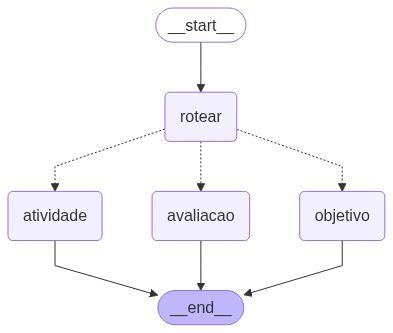

In [52]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Etapa 6 – RAG (Retrieval-Augmented Generation)

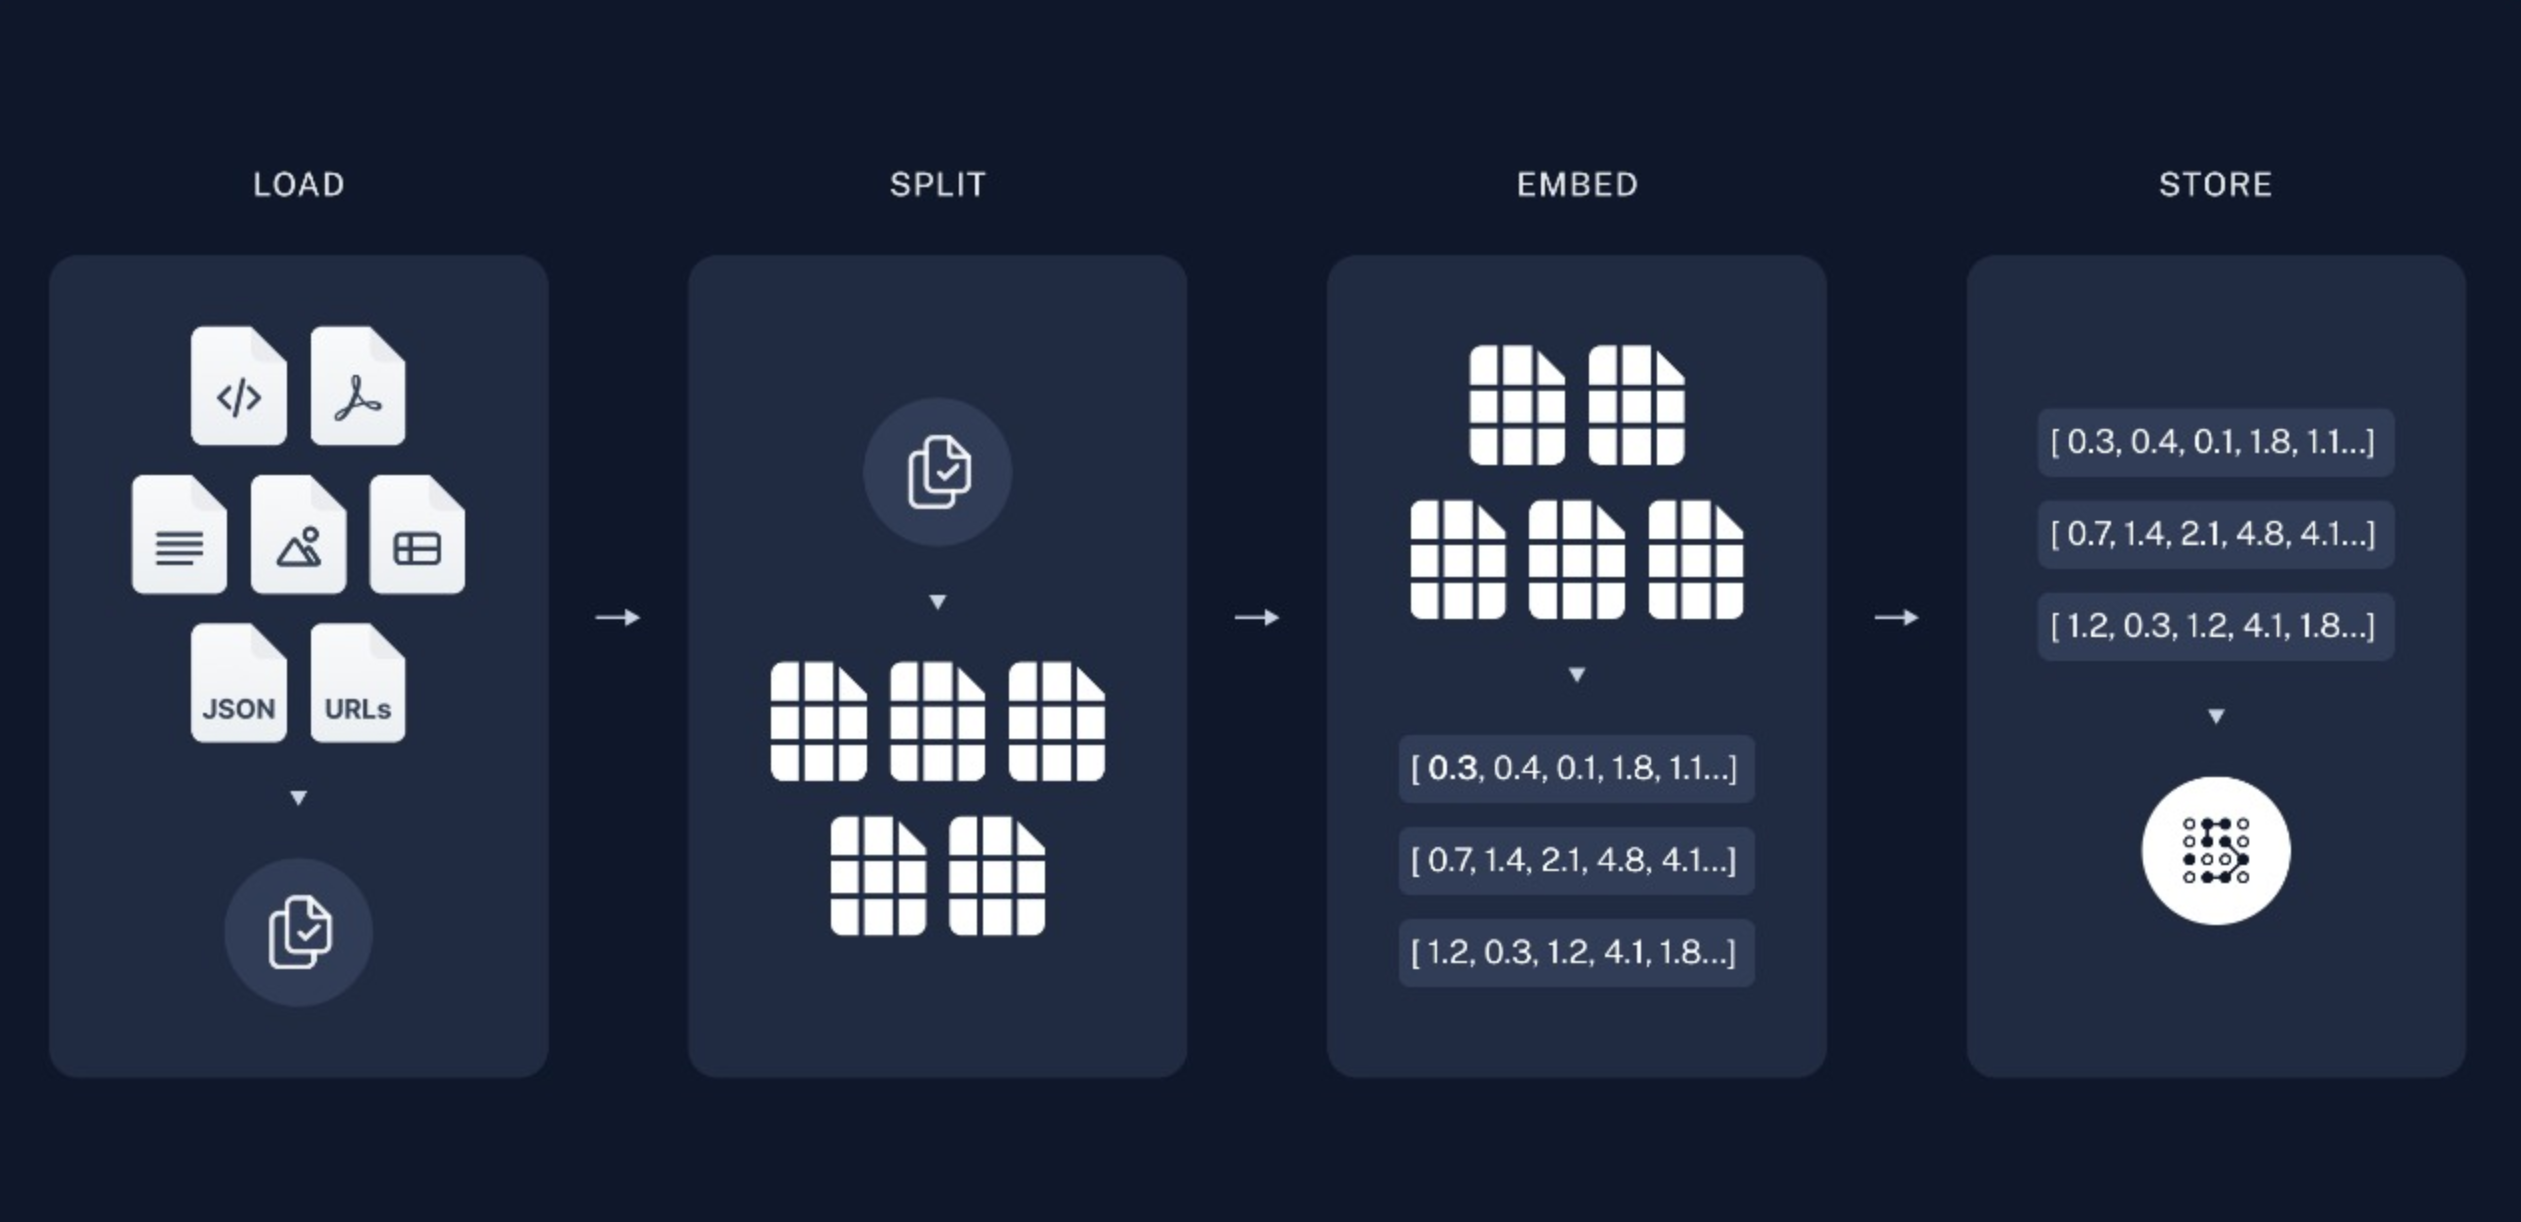


Nosso planejador de aulas ficou ótimo! Mas ele ainda depende apenas da "memória" do modelo. E se quisermos que ele consulte conteúdos pedagógicos reais, como apostilas, orientações da BNCC ou textos escolares?

Nesta etapa, vamos fazer com que o sistema busque informações relevantes em uma base de documentos, como PDFs ou textos previamente carregados, e só então gere a resposta.

In [54]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.chains import SimpleSequentialChain
from langchain.chains import LLMChain
from langchain.chains import ConversationChain
from langchain.globals import set_debug
from langchain_openai import OpenAIEmbeddings
from langchain.memory import ConversationSummaryMemory
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter
import os
from langchain_core.output_parsers import StrOutputParser
from langchain.chains import RetrievalQA

from dotenv import load_dotenv

load_dotenv()
set_debug(True)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5)

carregadores = [
    PyPDFLoader("fotossintese.pdf"),
]

documentos = []
for carregador in carregadores:
    documentos.extend(carregador.load())


quebrador = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
textos = quebrador.split_documents(documentos)
# print(textos)

embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(textos, embeddings)

qa_chain = RetrievalQA.from_chain_type(llm, retriever=db.as_retriever())

pergunta = "Na fotossíntese, onde ocorre fixação de CO2 com formação de um primeiro composto orgânico com 3 carbonos?"
resultado = qa_chain.invoke({ "query" : pergunta})
print(resultado)

[chain/start] [chain:RetrievalQA] Entering Chain run with input:
{
  "query": "Na fotossíntese, onde ocorre fixação de CO2 com formação de um primeiro composto orgânico com 3 carbonos?"
}
[chain/start] [chain:RetrievalQA > chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [chain:RetrievalQA > chain:StuffDocumentsChain > chain:LLMChain] Entering Chain run with input:
{
  "question": "Na fotossíntese, onde ocorre fixação de CO2 com formação de um primeiro composto orgânico com 3 carbonos?",
  "context": "Casa das Ciências rce.casadasciencias.org\n 4\namido. As células do mesófilo transferem CO 2 dos \nespaços intercelulares da folha onde a concentração \né baixa para as células da bainha do feixe, para que \na concentração seja suficientemente alta para manter \nativa a fotossíntese mesmo em dias quentes e secos \nem que os estomas fecham e a temperatura favorece \na atividade da RuBisCo oxigenase em vez da carboxi-\nlase. Porque a fotossíntese é mais efici

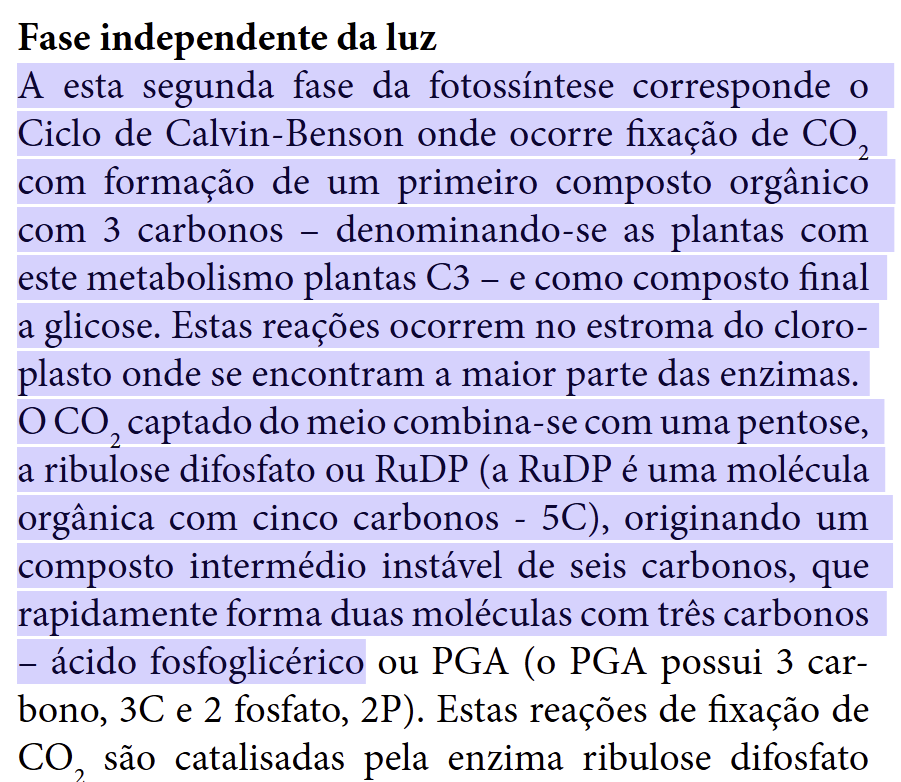